In [159]:
# Autor: Marcos Paulo
#
# Data: 06/04/2024
#
# Objetivo: Utilização de banco de dados para treinamento de modelo de machine learning


# Treinamento de Modelo com Base de Dados em Python

Utilizando a base de dados [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) e através da API [tf.keras](https://www.tensorflow.org/guide/keras?hl=pt-br), uma API de alto nível do TensorFlow para criar e treinar modelos de aprendizado profundo, vamos tentar prever alguns dos valores para a economia de combustíveis dos veículos do período selecionado nos dados.

Após instalar todas as bibliotecas, importamos todas elas e também o banco de dados em questão:

In [160]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras import layers

from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print(tf.__version__)


2.16.1


## Base de Dados

### Coleta de Dados Necessários

Após importar todo o necessário, iremos finalmente trazer os dados do banco para o código e, utilizando a biblioteca pandas, vamos transformá-los num dataframe que será utilizado e manipulado até o final:

In [161]:
# Buscando o conjunto de dados
auto_mpg = fetch_ucirepo(id=9) 

# Transformando em data frame
data = pd.DataFrame(auto_mpg.data.features, columns=auto_mpg.data.feature_name)
# Adicionando mpg ao dataframe
data['mpg'] = auto_mpg.data.targets



Antes de começar a limpeza dos dados, vamos dar uma olhada em como eles estão dispostos no data frame imprimindo o cabeçalho (5 primeiras linhas) e as estatíscas  do conjunto de dados:

In [162]:
# Visualizando os dados
print(data.head())

# Estatísticas dos dados
print(data.describe().transpose())

   displacement  cylinders  horsepower  weight  acceleration  model_year  \
0         307.0          8       130.0    3504          12.0          70   
1         350.0          8       165.0    3693          11.5          70   
2         318.0          8       150.0    3436          11.0          70   
3         304.0          8       150.0    3433          12.0          70   
4         302.0          8       140.0    3449          10.5          70   

   origin   mpg  
0       1  18.0  
1       1  15.0  
2       1  18.0  
3       1  16.0  
4       1  17.0  
              count         mean         std     min       25%     50%  \
displacement  398.0   193.425879  104.269838    68.0   104.250   148.5   
cylinders     398.0     5.454774    1.701004     3.0     4.000     4.0   
horsepower    392.0   104.469388   38.491160    46.0    75.000    93.5   
weight        398.0  2970.424623  846.841774  1613.0  2223.750  2803.5   
acceleration  398.0    15.568090    2.757689     8.0    13.825   

### Limpeza dos Dados

Agora, tendos os dados no nosso código, é necessário limpá-los antes de começar o treinamento com a rede neural da IA. Utilizando de algumas funções, vamos excluir dados que podem provocar erros e também melhorar a visualização do banco de dados como um todo.

In [163]:
# Limpando os dados

# Eliminando valores nulos
data = data.dropna()

# Convertendo a coluna 'origin' em one-hot encoding (3 colunas binarias para indicar origem)
origin = data.pop('origin')
data['EUA'] = (origin == 1) * 1.0
data['Europa'] = (origin == 2) * 1.0
data['Japao'] = (origin == 3) * 1.0

# Visualizando os dados
print(data.head())

   displacement  cylinders  horsepower  weight  acceleration  model_year  \
0         307.0          8       130.0    3504          12.0          70   
1         350.0          8       165.0    3693          11.5          70   
2         318.0          8       150.0    3436          11.0          70   
3         304.0          8       150.0    3433          12.0          70   
4         302.0          8       140.0    3449          10.5          70   

    mpg  EUA  Europa  Japao  
0  18.0  1.0     0.0    0.0  
1  15.0  1.0     0.0    0.0  
2  18.0  1.0     0.0    0.0  
3  16.0  1.0     0.0    0.0  
4  17.0  1.0     0.0    0.0  


### Dados de Teste e Treino

Separamos  os dados em conjuntos de treino e teste, com esse último sendo utilizado no final para que possamos comparar os dados obtidos após o treinamento do modelo. 

Após a separação, separamos a variável alvo e normalizamos os dados. A normalização dos dados é uma grande parte do aprendizado de máquina, pois nela podemos ajudar a melhorar a perfomance do modelo colocando recursos na mesma escala e inibindo uma possível alteração devido a um valor discrepante.
Nesse caso, vamos utilizar a classe **'StandardScaler'** que subtrai a média de cada recurso e divide pelo desvio padrão.


In [164]:
def preprocess_data(data):
    # Dividindo os dados em treino e teste
    train_data = data.sample(frac=0.8, random_state=0)
    test_data = data.drop(train_data.index)

    # A variável alvo é 'mpg' e vamos separá-la:
    train_labels = train_data.pop('mpg')
    test_labels = test_data.pop('mpg')

    # Normalizando os dados
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)

    return train_data, test_data, train_labels, test_labels

# Separando dados de treino e teste, pegando a variável alvo 'mpg' e normalizando
train_data, test_data, train_labels, test_labels = preprocess_data(data)

## Modelo de Treinamento

### Criação do Modelo

Através da **'keras.Sequential'** vamos construir o modelo de rede neural.
Esse podelo vai possuir duas camadas densas com 64 neurônios cada e a camada de saída com um único valor contínuo. 
A primeira camada densa tem a forma de entrada definida com o comprimento da entrada, que será o número de recursos do conjunto de dados que será utilizado no treinamento, e a segunda camada tem a tarefa de aprender os padrões das saídas da primeira camada densa. Já a terceira e última retorna a saída bruta do modelo.

A função de ativação ReLU (Rectified Linear Unit) é uma função de ativação não linear eficiente que ajuda a evitar o saturação dos neurônios, já que ela tenta não ativar todos de uma vez através da sua mecânica de gerenciamento de entradas negativas; se ela for zero, o neurônio não será ativado.

In [165]:
def model_maker(train_data):
    # Construindo o modelo
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_data[0])]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    # Compilando o modelo
    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.RMSprop(0.001),
        metrics=['mae', 'mse']
    )
    
    return model

# Criando e compilando o modelo
model = model_maker(train_data)


C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Treinamento do Modelo

Com o modelo criado, o próximo passo agora é treiná-lo. Vamos definir 1000 __EPOCHS__ (**epoch** é uma execução inteira do conjunto de dados de treinamento) para serem utilizados e vamos grava a acurácia do modelo.

A variável __early_stop__  é responsável por parar o treinamento quando  a precisão não está mais melhorando, reduzindo o tempo de execução do código em relação as 1000 repetições incialmente estipuladas.


In [166]:
def model_training(model, train_data, train_labels, validation_split):
    epochs = 1000
    # Essa variavel é usada para parar o treinamento quando o erro de validação não melhorar mais
    quality_control = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    start = time.time()
    history = model.fit(
        train_data, train_labels,
        epochs=epochs, validation_split=validation_split, verbose=0,
        callbacks=[quality_control])
    end = time.time()
    print("Tempo de treinamento: ", end - start)
    return history

# Treinando o modelo
history = model_training(model, train_data, train_labels, 0.2)

Tempo de treinamento:  5.41020131111145


Após o treinamento, plotamos o histórico do mesmo:

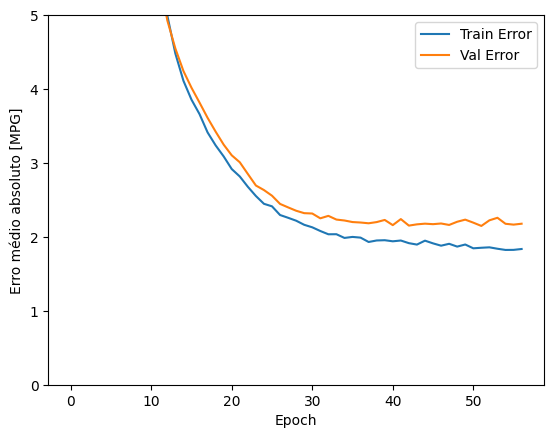

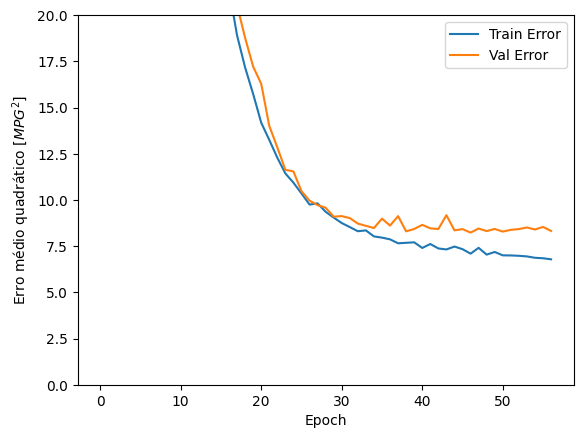

In [167]:
def plot_training(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Erro médio absoluto [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
        label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
        label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Erro médio quadrático [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
        label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
        label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

# Plotando o histórico de treinamento
plot_training(history)

Trazendo de volta aquele conjunto anteriormente reservado para o teste, podemos avaliar o modelo de rede neural com dados que não foram utilizados para seu treinamento e então tirar conclusões sobre como esse modelo se comportaria em situações reais.



In [168]:

# Avaliando o modelo
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=2)
accuracy = (1 - mae / test_labels.mean()) * 100
print("\nAcurácia do Modelo em porcentagem: {:5.2f}%".format(accuracy))
print('\nErro médio absoluto do MPG:  +/- {:5.2f}'.format(mae))

3/3 - 0s - 15ms/step - loss: 6.1647 - mae: 1.8063 - mse: 5.7661

Acurácia do Modelo em porcentagem: 92.47%

Erro médio absoluto do MPG:  +/-  1.81


É possível então, perceber que a acurácia do modelo gira em torno de determinado *__MPG__* e tem uma precisão boa, mas que depende da aplicação.

### Predições Utilizando o Modelo

Com o conjunto de testes reservado, o modelo criado irá fazer predições para os valores de MPG. 

Através do seguinte gráfico, é possível enxergar melhor como os dados previstos se comparam  com a realidade:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


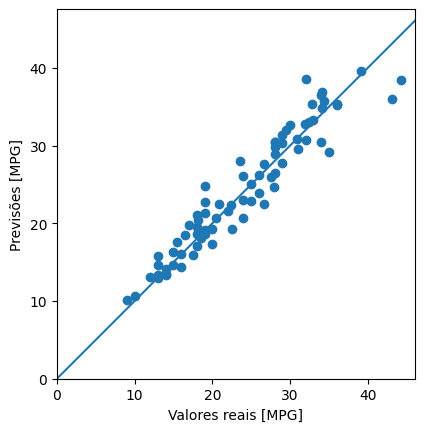

In [169]:
# Fazendo predições
test_predictions = model.predict(test_data).flatten()
def plot_predictions(test_labels, test_predictions):
    # Plotando a previsão com a realidade
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('Valores reais [MPG]')
    plt.ylabel('Previsões [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])
    plt.show()

# Plotando a previsão com a realidade
plot_predictions(test_labels, test_predictions)

Visualizando o gráfico, é possível dizer que o modelo treinado consegue predir razoavelmente bem os valores de *__MPG__*.

Por fim, vamos dar uma olhada distribuição de erros, que irá nos dizer a classificação de cada erro de acordo com o grau de frequência do valor errado.

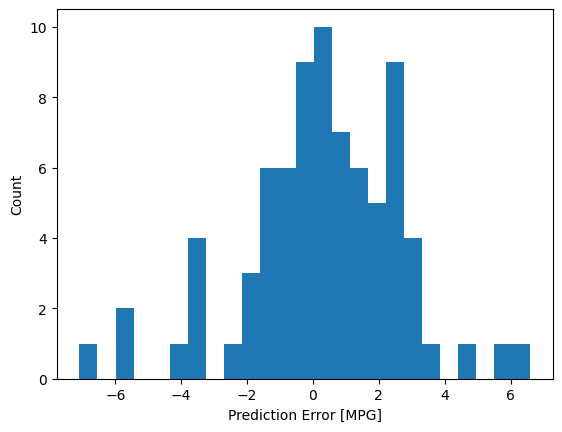

In [170]:
def plot_error_distribution(predictions, labels):
    error = predictions - labels
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error [MPG]")
    plt.ylabel("Count")
    plt.show()

# Plotando a distribuição do erro
plot_error_distribution(test_predictions, test_labels)

## Conclusão

Após o treinamento do modelo, obtemos bons resultados com as técnicas utilizadas seja de treinamento, como a técnica de __*early stopping*__, ou de métricas para analisar a acurácia do modelo, sendo a MSE e a MAE escolhidas para estipular tais perdas. Os gráficos plotados servem para exemplificar de maneira mais interativa os dados obtidos.
